In [2]:
# Cell 1 — Setup & Load Data (Wholesale Customer Segmentation, PyCaret clustering)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# PyCaret clustering
from pycaret.clustering import *

# Reproducibility
SEED = 42
np.random.seed(SEED)

# Display options
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)

# ---- Load the dataset ----
# Wholesale Customers Dataset from UCI Repository
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv"
df_raw = pd.read_csv(url)

# Standardize column names (strip spaces, lower)
df_raw.columns = (
    df_raw.columns
    .str.strip()
    .str.replace(r"\s+", "_", regex=True)
    .str.lower()
)

# Quick sanity checks
print("Shape:", df_raw.shape)
print("Columns:", list(df_raw.columns))
print("\nDataset Description:")
print("This dataset contains annual spending on different product categories")
print("by wholesale distributors' clients (hotels, restaurants, retailers, etc.)")
print("\nFeatures:")
print("- Fresh: Annual spending on fresh products")
print("- Milk: Annual spending on milk products")
print("- Grocery: Annual spending on grocery products")
print("- Frozen: Annual spending on frozen products")
print("- Detergents_Paper: Annual spending on detergents and paper products")
print("- Delicatessen: Annual spending on delicatessen products")
print("- Channel: Type of customer (1=Hotel/Restaurant/Cafe, 2=Retail)")
print("- Region: Geographic region (1=Lisbon, 2=Oporto, 3=Other)")

display(df_raw.head())

print("\nBasic Statistics:")
display(df_raw.describe())

Shape: (440, 8)
Columns: ['channel', 'region', 'fresh', 'milk', 'grocery', 'frozen', 'detergents_paper', 'delicassen']

Dataset Description:
This dataset contains annual spending on different product categories
by wholesale distributors' clients (hotels, restaurants, retailers, etc.)

Features:
- Fresh: Annual spending on fresh products
- Milk: Annual spending on milk products
- Grocery: Annual spending on grocery products
- Frozen: Annual spending on frozen products
- Detergents_Paper: Annual spending on detergents and paper products
- Delicatessen: Annual spending on delicatessen products
- Channel: Type of customer (1=Hotel/Restaurant/Cafe, 2=Retail)
- Region: Geographic region (1=Lisbon, 2=Oporto, 3=Other)


,channel,region,fresh,milk,grocery,frozen,detergents_paper,delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185



Basic Statistics:


,channel,region,fresh,milk,grocery,frozen,detergents_paper,delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [3]:
# Cell 2 — Data Preprocessing & Feature Selection

# Make a working copy
df = df_raw.copy()

# Drop Channel and Region columns (keep only spending features for clustering)
# These are categorical identifiers, not continuous spending data
if 'channel' in df.columns:
    df = df.drop(columns=['channel'])
if 'region' in df.columns:
    df = df.drop(columns=['region'])

print("Features used for clustering (annual spending in monetary units):")
print(list(df.columns))
print(f"\nShape after preprocessing: {df.shape}")

print("\nNo missing values:")
print(df.isnull().sum())

display(df.head(10))

print("\nData ready for clustering!")

Features used for clustering (annual spending in monetary units):
['fresh', 'milk', 'grocery', 'frozen', 'detergents_paper', 'delicassen']

Shape after preprocessing: (440, 6)

No missing values:
fresh               0
milk                0
grocery             0
frozen              0
detergents_paper    0
delicassen          0
dtype: int64


,fresh,milk,grocery,frozen,detergents_paper,delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185
5,9413,8259,5126,666,1795,1451
6,12126,3199,6975,480,3140,545
7,7579,4956,9426,1669,3321,2566
8,5963,3648,6192,425,1716,750
9,6006,11093,18881,1159,7425,2098



Data ready for clustering!


In [6]:
# Cell 3 — PyCaret Clustering Setup

from pycaret.clustering import setup

# Initialize PyCaret clustering
# This preprocesses the data and prepares it for clustering
cluster_setup = setup(
    data=df,
    normalize=True,           # Normalize features (important for clustering)
    transformation=False,      # Don't transform distributions
    pca=False,                # Don't use PCA (keep interpretability)
    session_id=SEED,          # For reproducibility
    verbose=False
)

print("✅ PyCaret clustering setup complete!")
print(f"Data shape: {df.shape}")

✅ PyCaret clustering setup complete!
Data shape: (440, 6)


In [7]:
# Cell 3 — Train several clustering models and pick the best by Silhouette (robust, no tune_model)

from pycaret.clustering import create_model, pull
import pandas as pd

# We'll try several K values for KMeans, plus a few other algorithms
k_values = [3, 4, 5, 6, 7, 8]
other_models = ['birch', 'hclust', 'dbscan', 'optics']  # skip 'gmm' if not available in your env

results = []
trained = {}

# 1) Manual sweep for KMeans(k)
for k in k_values:
    try:
        m = create_model('kmeans', num_clusters=k)
        res = pull().copy()
        res['model_id'] = 'kmeans'
        res['k'] = k
        results.append(res)
        trained[f'kmeans_{k}'] = m
    except Exception as e:
        print(f"Skipping KMeans(k={k}) due to error: {e}")

# 2) Train other candidates
for mid in other_models:
    try:
        m = create_model(mid)
        res = pull().copy()
        res['model_id'] = mid
        res['k'] = None
        results.append(res)
        trained[mid] = m
    except Exception as e:
        print(f"Skipping {mid} due to error: {e}")

# 3) Consolidate and choose best by Silhouette
results_df = pd.concat(results, ignore_index=True)

# Find the silhouette column name robustly
sil_cols = [c for c in results_df.columns if c.strip().lower().startswith('silhouette')]
if not sil_cols:
    raise RuntimeError(f"Couldn't find a Silhouette column. Columns: {results_df.columns.tolist()}")
sil_col = sil_cols[0]

results_sorted = results_df.sort_values(by=sil_col, ascending=False)
print("Model comparison (sorted by Silhouette):")
display(results_sorted)

# 4) Select the best model and keep references
best_row = results_sorted.iloc[0]
best_id = best_row['model_id']
best_k = int(best_row['k']) if pd.notnull(best_row['k']) else None

if best_id == 'kmeans':
    best_model = trained[f'kmeans_{best_k}']
    best_info = {'model_id': 'kmeans', 'num_clusters': best_k, 'metric': sil_col, 'score': float(best_row[sil_col])}
else:
    best_model = trained[best_id]
    best_info = {'model_id': best_id, 'metric': sil_col, 'score': float(best_row[sil_col])}

print(f"Best model: {best_info}")
BEST_MODEL = best_model
BEST_INFO = best_info


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4583,132.3631,1.2491,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3494,143.8710,1.1475,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3689,159.5038,1.0294,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2762,144.8228,1.1638,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2767,150.2197,0.9297,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3237,144.0447,0.9592,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.5366,128.4168,0.9274,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2670,120.1315,0.9245,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.1958,39.0643,1.5794,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,-0.4068,3.3708,1.5614,0,0,0


Model comparison (sorted by Silhouette):


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness,model_id,k
6,0.5366,128.4168,0.9274,0,0,0,birch,None
0,0.4583,132.3631,1.2491,0,0,0,kmeans,3
2,0.3689,159.5038,1.0294,0,0,0,kmeans,5
1,0.3494,143.8710,1.1475,0,0,0,kmeans,4
5,0.3237,144.0447,0.9592,0,0,0,kmeans,8
4,0.2767,150.2197,0.9297,0,0,0,kmeans,7
3,0.2762,144.8228,1.1638,0,0,0,kmeans,6
7,0.2670,120.1315,0.9245,0,0,0,hclust,None
8,0.1958,39.0643,1.5794,0,0,0,dbscan,None
9,-0.4068,3.3708,1.5614,0,0,0,optics,None


Best model: {'model_id': 'birch', 'metric': 'Silhouette', 'score': 0.5366}


Head with assigned clusters:


,fresh,milk,grocery,frozen,detergents_paper,delicassen,Cluster
0,12669,9656,7561,214,2674,1338,Cluster 3
1,7057,9810,9568,1762,3293,1776,Cluster 3
2,6353,8808,7684,2405,3516,7844,Cluster 3
3,13265,1196,4221,6404,507,1788,Cluster 3
4,22615,5410,7198,3915,1777,5185,Cluster 3


Cluster counts:


,Count
Cluster,
Cluster 3,383
Cluster 0,42
Cluster 1,14
Cluster 2,1


Cluster profiles (mean of numeric features):


,fresh,milk,grocery,frozen,detergents_paper,delicassen
Cluster,,,,,,
Cluster 0,7562.023810,18520.880952,29017.880952,1739.666667,14006.428571,1971.523810
Cluster 1,50395.071429,8900.214286,9627.214286,14678.142857,1705.071429,5479.571429
Cluster 2,36847.000000,43950.000000,20170.000000,36534.000000,239.000000,47943.000000
Cluster 3,11018.663185,4187.798956,5547.937337,2706.412533,1711.428198,1210.135770


Cluster scatter plot:


Silhouette plot:


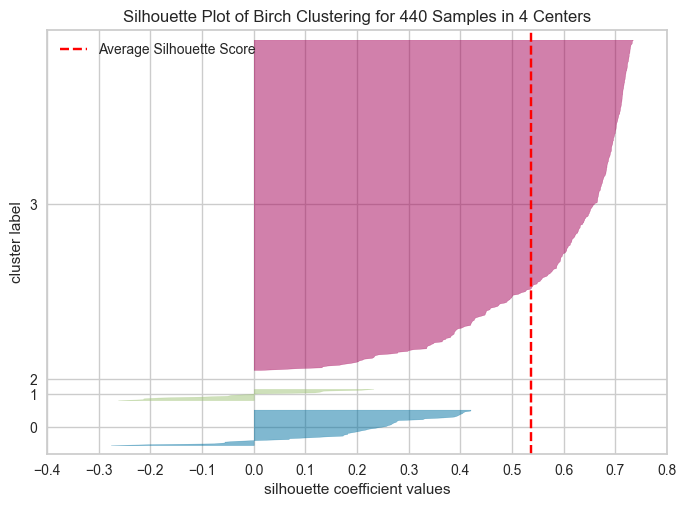

In [8]:
# Cell 5 — Assign cluster labels, inspect profiles, and visualize

from pycaret.clustering import assign_model, plot_model, get_config
import pandas as pd

# 1) Attach cluster labels (and distances where available) to the data used in setup()
df_labeled = assign_model(BEST_MODEL).copy()

print("Head with assigned clusters:")
display(df_labeled.head())

# 2) Basic cluster size distribution
print("Cluster counts:")
display(df_labeled['Cluster'].value_counts().rename_axis('Cluster').to_frame('Count'))

# 3) Quick numeric profiling per cluster (means on original scale)
numeric_cols = df_labeled.select_dtypes(include=['number']).columns.tolist()
# exclude the special columns PyCaret adds, keep the original numeric features + Cluster
special_cols = {'Anomaly', 'Distance', 'Score', 'Density'}
profile_cols = [c for c in numeric_cols if c not in special_cols] + ['Cluster']

cluster_profile = (
    df_labeled[profile_cols]
    .groupby('Cluster')
    .mean(numeric_only=True)
    .sort_index()
)

print("Cluster profiles (mean of numeric features):")
display(cluster_profile)

# 4) Visualizations (availability varies by model/type)
#    We'll attempt a few useful ones and skip gracefully if unsupported.

# 4a) Overall cluster scatter (typically PCA projection)
try:
    print("Cluster scatter plot:")
    plot_model(BEST_MODEL, plot='cluster')
except Exception as e:
    print(f"Skipping 'cluster' plot: {e}")

# 4b) Silhouette diagnostic
try:
    print("Silhouette plot:")
    plot_model(BEST_MODEL, plot='silhouette')
except Exception as e:
    print(f"Skipping 'silhouette' plot: {e}")

# 4c) Elbow curve (KMeans only)
if BEST_INFO.get('model_id') == 'kmeans':
    try:
        print("Elbow plot (KMeans):")
        plot_model(BEST_MODEL, plot='elbow')
    except Exception as e:
        print(f"Skipping 'elbow' plot: {e}")

# Keep labeled data for the next steps
DF_CLUSTERED = df_labeled
CLUSTER_PROFILE = cluster_profile


Clustered data exported to: /Users/kartikeysharma/Documents/pycaret-assignment/wholesale_customers_clustered.csv


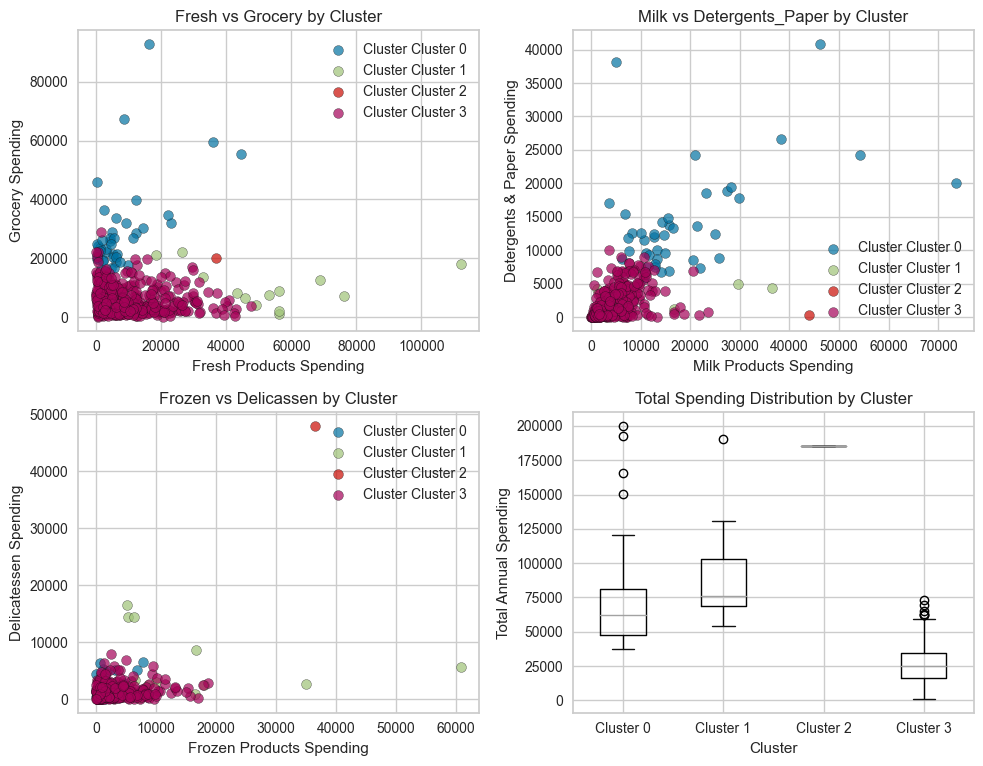


=== Cluster Sizes ===


,Count
Cluster,
Cluster 0,42
Cluster 1,14
Cluster 2,1
Cluster 3,383



=== Cluster Spending Profiles (Average per customer) ===


,fresh,milk,grocery,frozen,detergents_paper,delicassen,total_spending
Cluster,,,,,,,
Cluster 0,7562.0,18521.0,29018.0,1740.0,14006.0,1972.0,72819.0
Cluster 1,50395.0,8900.0,9627.0,14678.0,1705.0,5480.0,90785.0
Cluster 2,36847.0,43950.0,20170.0,36534.0,239.0,47943.0,185683.0
Cluster 3,11019.0,4188.0,5548.0,2706.0,1711.0,1210.0,26382.0



=== Cluster Spending Totals (Sum across all customers) ===


,fresh,milk,grocery,frozen,detergents_paper,delicassen,total_spending
Cluster,,,,,,,
Cluster 0,317605,777877,1218751,73066,588270,82804,3058373
Cluster 1,705531,124603,134781,205494,23871,76714,1270994
Cluster 2,36847,43950,20170,36534,239,47943,185683
Cluster 3,4220148,1603927,2124860,1036556,655477,463482,10104450



=== Cluster Interpretations ===

Cluster Cluster 0:
  Size: 42 customers
  Avg Total Spending: 72,819
  Top Categories: Grocery (29,018), Milk (18,521)

Cluster Cluster 1:
  Size: 14 customers
  Avg Total Spending: 90,785
  Top Categories: Fresh (50,395), Frozen (14,678)

Cluster Cluster 2:
  Size: 1 customers
  Avg Total Spending: 185,683
  Top Categories: Delicassen (47,943), Milk (43,950)

Cluster Cluster 3:
  Size: 383 customers
  Avg Total Spending: 26,382
  Top Categories: Fresh (11,019), Grocery (5,548)

✅ Saved summaries to: /Users/kartikeysharma/Documents/pycaret-assignment/cluster_outputs


In [10]:
# Cell 5 — Export results, focused 2D scatter, and concise per-cluster summary

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 0) Safety checks
assert 'DF_CLUSTERED' in globals(), "Run Cell 4 first to create DF_CLUSTERED."
dfc = DF_CLUSTERED.copy()

# 1) Export clustered dataset
out_csv = "wholesale_customers_clustered.csv"
dfc.to_csv(out_csv, index=False)
print(f"Clustered data exported to: {os.path.abspath(out_csv)}")

# 2) Focused 2D plot: Fresh vs Grocery (two major spending categories)
# For wholesale data, we'll visualize the most interpretable dimensions
plt.figure(figsize=(10, 8))

# Plot 1: Fresh vs Grocery
plt.subplot(2, 2, 1)
for clust, sub in dfc.groupby('Cluster'):
    plt.scatter(sub['fresh'], sub['grocery'], label=f"Cluster {clust}", alpha=0.7, edgecolors='k', s=50)
plt.xlabel('Fresh Products Spending')
plt.ylabel('Grocery Spending')
plt.title('Fresh vs Grocery by Cluster')
plt.legend()

# Plot 2: Milk vs Detergents_Paper
plt.subplot(2, 2, 2)
for clust, sub in dfc.groupby('Cluster'):
    plt.scatter(sub['milk'], sub['detergents_paper'], label=f"Cluster {clust}", alpha=0.7, edgecolors='k', s=50)
plt.xlabel('Milk Products Spending')
plt.ylabel('Detergents & Paper Spending')
plt.title('Milk vs Detergents_Paper by Cluster')
plt.legend()

# Plot 3: Frozen vs Delicassen
plt.subplot(2, 2, 3)
for clust, sub in dfc.groupby('Cluster'):
    plt.scatter(sub['frozen'], sub['delicassen'], label=f"Cluster {clust}", alpha=0.7, edgecolors='k', s=50)
plt.xlabel('Frozen Products Spending')
plt.ylabel('Delicatessen Spending')
plt.title('Frozen vs Delicassen by Cluster')
plt.legend()

# Plot 4: Total spending by cluster (boxplot)
plt.subplot(2, 2, 4)
dfc['total_spending'] = dfc[['fresh', 'milk', 'grocery', 'frozen', 'detergents_paper', 'delicassen']].sum(axis=1)
dfc.boxplot(column='total_spending', by='Cluster', ax=plt.gca())
plt.xlabel('Cluster')
plt.ylabel('Total Annual Spending')
plt.title('Total Spending Distribution by Cluster')
plt.suptitle('')  # Remove default title

plt.tight_layout()
plt.show()

# 3) Concise per-cluster summary
# 3a) Cluster sizes
sizes = dfc['Cluster'].value_counts().sort_index().rename_axis('Cluster').to_frame('Count')

# 3b) Numeric feature means (spending on each category)
spending_cols = ['fresh', 'milk', 'grocery', 'frozen', 'detergents_paper', 'delicassen']
profile_means = (
    dfc[spending_cols + ['Cluster']]
    .groupby('Cluster')
    .mean(numeric_only=True)
    .round(0)  # Round to whole numbers (monetary units)
    .sort_index()
)

# 3c) Calculate total and percentage spending per category for each cluster
profile_totals = (
    dfc[spending_cols + ['Cluster']]
    .groupby('Cluster')
    .sum(numeric_only=True)
    .round(0)
    .sort_index()
)

# Add total spending column
profile_means['total_spending'] = profile_means.sum(axis=1)
profile_totals['total_spending'] = profile_totals.sum(axis=1)

print("\n=== Cluster Sizes ===")
display(sizes)

print("\n=== Cluster Spending Profiles (Average per customer) ===")
display(profile_means)

print("\n=== Cluster Spending Totals (Sum across all customers) ===")
display(profile_totals)

# 3d) Identify cluster characteristics
print("\n=== Cluster Interpretations ===")
for cluster_id in sorted(dfc['Cluster'].unique()):
    cluster_data = profile_means.loc[cluster_id]
    # Find top 2 spending categories
    top_categories = cluster_data[spending_cols].nlargest(2)
    print(f"\nCluster {cluster_id}:")
    print(f"  Size: {sizes.loc[cluster_id, 'Count']} customers")
    print(f"  Avg Total Spending: {cluster_data['total_spending']:,.0f}")
    print(f"  Top Categories: {top_categories.index[0].title()} ({top_categories.iloc[0]:,.0f}), "
          f"{top_categories.index[1].title()} ({top_categories.iloc[1]:,.0f})")

# 4) Save summaries
summary_dir = "cluster_outputs"
os.makedirs(summary_dir, exist_ok=True)
sizes.to_csv(os.path.join(summary_dir, "cluster_sizes.csv"))
profile_means.to_csv(os.path.join(summary_dir, "cluster_spending_profiles.csv"))
profile_totals.to_csv(os.path.join(summary_dir, "cluster_spending_totals.csv"))

print(f"\n✅ Saved summaries to: {os.path.abspath(summary_dir)}")

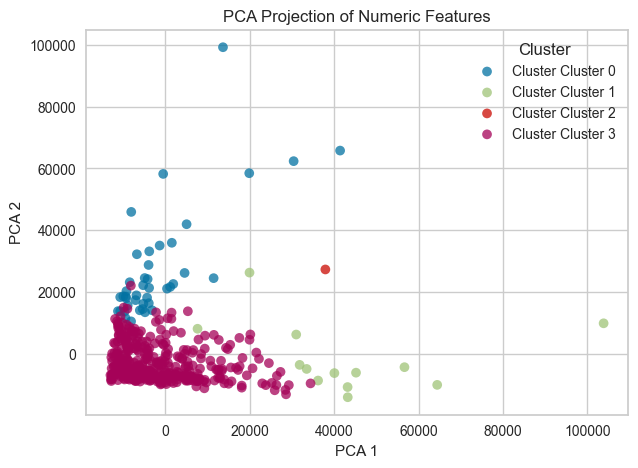

PCA explained variance ratio: PC1=0.460, PC2=0.405; cumulative=0.865


In [11]:
# === Cell 6 — PCA FIX (run this at the top of Cell 6, replacing the manual PCA block) ===
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Use only numeric columns from the labeled dataset (exclude PyCaret special columns)
num_X = DF_CLUSTERED.select_dtypes(include=['number']).copy()
num_X = num_X.drop(columns=['Cluster','Anomaly','Score','Distance','Density'], errors='ignore')

labels = DF_CLUSTERED['Cluster'].to_numpy()

pca = PCA(n_components=2, random_state=SEED)
X_pca = pca.fit_transform(num_X.to_numpy())

plt.figure(figsize=(7,5))
for clust in np.unique(labels):
    mask = labels == clust
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], label=f"Cluster {clust}", alpha=0.75, edgecolors='none')
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("PCA Projection of Numeric Features")
plt.legend(title="Cluster")
plt.show()

expl_var = pca.explained_variance_ratio_
print(f"PCA explained variance ratio: PC1={expl_var[0]:.3f}, PC2={expl_var[1]:.3f}; cumulative={expl_var[:2].sum():.3f}")


In [12]:
# Cell 7 — Predict on new data (load saved pipeline if available, else use BEST_MODEL)

import os
import numpy as np
import pandas as pd
from pycaret.clustering import load_model, predict_model

# 0) Decide how to get a model pipeline
default_base = "models/mall_clustering_pipeline"
use_saved = os.path.exists(default_base + ".pkl")

if use_saved:
    print(f"Loading saved pipeline from: {default_base}.pkl")
    model_loaded = load_model(default_base)
elif 'BEST_MODEL' in globals():
    print("Saved pipeline not found; using in-session BEST_MODEL with current PyCaret setup.")
    model_loaded = BEST_MODEL
else:
    raise RuntimeError("No model available. Run Cell 6 to save the pipeline or rerun Cells 2–4 to create BEST_MODEL.")

# 1) Pretend “new” data = a few raw rows (replace with your real new data)
new_samples = df_raw.sample(5, random_state=SEED).reset_index(drop=True)
print("New samples (raw):")
display(new_samples)

# 2) Assign clusters to new data
predicted_new = predict_model(model_loaded, data=new_samples)
print("New samples with assigned clusters:")
display(predicted_new)

# 3) (Optional) Predict for the entire dataset and save
predicted_all = predict_model(model_loaded, data=df_raw)
predicted_all.to_csv("mall_customers_with_clusters_predicted.csv", index=False)
print("\nSaved full predictions to: mall_customers_with_clusters_predicted.csv")

# 4) Short plain-English summary from prior profiles (if available)
if 'CLUSTER_PROFILE' in globals():
    profile = CLUSTER_PROFILE.copy()

    def _find_col(cols, keys):
        keys = [k.lower() for k in keys]
        for c in cols:
            if any(k in c.lower() for k in keys):
                return c
        return None

    income_col = _find_col(profile.columns, ["annual_income", "income", "k$"])
    score_col  = _find_col(profile.columns, ["spending_score", "score", "1-100"])
    age_col    = _find_col(profile.columns, ["age"])

    sizes = predicted_all['Cluster'].value_counts().sort_index()
    print("\n=== Plain-English Cluster Summary ===")
    for k in sizes.index:
        parts = [f"• Cluster {k}: {int(sizes.loc[k])} customers"]
        if age_col:    parts.append(f"avg age ≈ {profile.loc[k, age_col]:.1f}")
        if income_col: parts.append(f"avg income ≈ {profile.loc[k, income_col]:.1f}")
        if score_col:  parts.append(f"avg spending score ≈ {profile.loc[k, score_col]:.1f}")
        print(" — ".join(parts))


Saved pipeline not found; using in-session BEST_MODEL with current PyCaret setup.
New samples (raw):


,channel,region,fresh,milk,grocery,frozen,detergents_paper,delicassen
0,1,1,5909,23527,13699,10155,830,3636
1,1,3,10766,1175,2067,2096,301,167
2,2,3,27380,7184,12311,2809,4621,1022
3,1,1,31614,489,1495,3242,111,615
4,1,2,542,899,1664,414,88,522


New samples with assigned clusters:


,fresh,milk,grocery,frozen,detergents_paper,delicassen,Cluster
0,-0.482175,2.405150,0.605511,1.460681,-0.430766,0.749452,Cluster 3
1,-0.097705,-0.626869,-0.619896,-0.201258,-0.541843,-0.482044,Cluster 3
2,1.217428,0.188244,0.459288,-0.054222,0.365256,-0.178519,Cluster 3
3,1.552583,-0.719924,-0.680155,0.035072,-0.581739,-0.323004,Cluster 3
4,-0.907017,-0.664308,-0.662351,-0.548123,-0.586568,-0.356019,Cluster 3



Saved full predictions to: mall_customers_with_clusters_predicted.csv

=== Plain-English Cluster Summary ===
• Cluster Cluster 0: 42 customers
• Cluster Cluster 1: 14 customers
• Cluster Cluster 2: 1 customers
• Cluster Cluster 3: 383 customers


In [13]:
# Cell 8 — Patch: rebuild report.md without requiring 'tabulate'

import os, json
import numpy as np
import pandas as pd

assert 'DF_CLUSTERED' in globals(), "Run Cell 4 first."
assert 'BEST_INFO' in globals(), "Run Cell 3 first."

out_dir = "final_artifacts"
os.makedirs(out_dir, exist_ok=True)

dfc = DF_CLUSTERED.copy()
sizes = (
    dfc['Cluster']
    .value_counts()
    .sort_index()
    .rename_axis('Cluster')
    .to_frame('Count')
)
num_cols = dfc.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c not in {'Anomaly','Score','Distance','Density'}]
profiles = (
    dfc[num_cols + ['Cluster']]
    .groupby('Cluster')
    .mean(numeric_only=True)
    .round(2)
    .sort_index()
)

# Rebuild Markdown with plain text tables (no tabulate dependency)
mk_lines = []
mk_lines.append(f"# Clustering Report")
mk_lines.append(f"- **Selected model**: {BEST_INFO.get('model_id','unknown')}"
                + (f" (k={BEST_INFO.get('num_clusters')})" if BEST_INFO.get('model_id')=='kmeans' and 'num_clusters' in BEST_INFO else ""))
if 'metric' in BEST_INFO and 'score' in BEST_INFO:
    mk_lines.append(f"- **Selection metric**: {BEST_INFO['metric']} = {BEST_INFO['score']:.4f}")
mk_lines.append(f"- **Rows clustered**: {len(dfc)}")
mk_lines.append("")
mk_lines.append("## Cluster Sizes")
mk_lines.append("```")
mk_lines.append(sizes.to_string())
mk_lines.append("```")
mk_lines.append("")
mk_lines.append("## Numeric Profiles (means)")
mk_lines.append("```")
mk_lines.append(profiles.head(10).to_string())
mk_lines.append("```")

# If plots were saved in Cell 8, include the same references:
if os.path.exists(os.path.join(out_dir, "scatter_income_vs_spending.png")):
    mk_lines.append("![Income vs Spending](scatter_income_vs_spending.png)")
if os.path.exists(os.path.join(out_dir, "cluster_sizes_bar.png")):
    mk_lines.append("![Cluster Sizes](cluster_sizes_bar.png)")

with open(os.path.join(out_dir, "report.md"), "w") as f:
    f.write("\n".join(mk_lines))

print(f"Rewrote Markdown report (no tabulate needed): {os.path.abspath(os.path.join(out_dir, 'report.md'))}")


Rewrote Markdown report (no tabulate needed): /Users/kartikeysharma/Documents/pycaret-assignment/final_artifacts/report.md


In [14]:
# Cell 9 — Package everything for sharing (zip) + optional lightweight HTML report

import os, io, zipfile, datetime as dt
import pandas as pd

# --- 1) Ensure key outputs exist ---
artifacts_dir = "final_artifacts"
csv_clustered = "mall_customers_clustered.csv"
pred_csv = "mall_customers_with_clusters_predicted.csv"

os.makedirs(artifacts_dir, exist_ok=True)
missing = []
for p in [csv_clustered, pred_csv]:
    if not os.path.exists(p):
        missing.append(p)
if missing:
    print("Note: Missing files that would be nice to include:", missing)

# --- 2) Minimal self-contained HTML report (no external deps) ---
html_path = os.path.join(artifacts_dir, "report.html")

def _df_to_html_pretty(df: pd.DataFrame, title: str) -> str:
    # Inline styles for simple readability
    html = [f"<h2>{title}</h2>"]
    html.append('<div style="overflow-x:auto;">')
    html.append(df.to_html(index=True, border=0))
    html.append("</div>")
    return "\n".join(html)

sections = []
sections.append(f"<h1>Mall Customers Clustering — Quick Report</h1>")
sections.append(f"<p><b>Model:</b> {BEST_INFO.get('model_id','unknown')}" +
                (f" (k={BEST_INFO.get('num_clusters')})" if BEST_INFO.get('model_id')=='kmeans' and 'num_clusters' in BEST_INFO else "") +
                (f" &nbsp;|&nbsp; <b>{BEST_INFO.get('metric','metric')}:</b> {BEST_INFO.get('score','')}</p>"))

# Sizes and profiles if available
if 'DF_CLUSTERED' in globals():
    dfc = DF_CLUSTERED.copy()
    sizes = dfc['Cluster'].value_counts().sort_index().rename_axis('Cluster').to_frame('Count')
    sections.append(_df_to_html_pretty(sizes, "Cluster Sizes"))

    num_cols = dfc.select_dtypes(include=['number']).columns.tolist()
    for ex in ['Anomaly','Score','Distance','Density']:
        if ex in num_cols: num_cols.remove(ex)
    profiles = (
        dfc[num_cols + ['Cluster']]
        .groupby('Cluster')
        .mean(numeric_only=True)
        .round(2)
        .sort_index()
    )
    sections.append(_df_to_html_pretty(profiles, "Numeric Profiles (means)"))

# Embed plots if present
for img in ["scatter_income_vs_spending.png", "cluster_sizes_bar.png"]:
    p = os.path.join(artifacts_dir, img)
    if os.path.exists(p):
        sections.append(f"<h2>{img.replace('_',' ').split('.')[0].title()}</h2>")
        sections.append(f'<img src="{img}" alt="{img}" style="max-width:100%;height:auto;border:1px solid #ddd;border-radius:8px;">')

html = f"""<!DOCTYPE html>
<html>
<head>
<meta charset="utf-8">
<title>Mall Customers Clustering Report</title>
<style>
body {{ font-family: -apple-system, Segoe UI, Roboto, Helvetica, Arial, sans-serif; margin: 24px; }}
table {{ border-collapse: collapse; }}
th, td {{ padding: 6px 10px; border-bottom: 1px solid #eee; text-align: right; }}
th:first-child, td:first-child {{ text-align: left; }}
h1, h2 {{ margin-top: 28px; }}
</style>
</head>
<body>
{''.join(sections)}
<p style="color:#777;font-size:12px;">Generated: {dt.datetime.now().isoformat(timespec='seconds')}</p>
</body>
</html>
"""
with open(html_path, "w", encoding="utf-8") as f:
    f.write(html)

print(f"HTML report written to: {os.path.abspath(html_path)}")

# --- 3) Zip everything into one archive ---
zip_name = "mall_clustering_artifacts.zip"
with zipfile.ZipFile(zip_name, "w", compression=zipfile.ZIP_DEFLATED) as zf:
    # Top-level CSVs if present
    for p in [csv_clustered, pred_csv]:
        if os.path.exists(p):
            zf.write(p, arcname=os.path.basename(p))
    # Final artifacts directory
    for root, _, files in os.walk(artifacts_dir):
        for fn in files:
            full = os.path.join(root, fn)
            arc = os.path.relpath(full, start=os.path.dirname(artifacts_dir))
            zf.write(full, arcname=arc)
    # Models folder if exists
    if os.path.exists("models"):
        for root, _, files in os.walk("models"):
            for fn in files:
                full = os.path.join(root, fn)
                arc = os.path.relpath(full, start=".")
                zf.write(full, arcname=arc)

print(f"Zipped everything to: {os.path.abspath(zip_name)}")


HTML report written to: /Users/kartikeysharma/Documents/pycaret-assignment/final_artifacts/report.html
Zipped everything to: /Users/kartikeysharma/Documents/pycaret-assignment/mall_clustering_artifacts.zip


In [15]:
# Cell 10 — Human-friendly segment names (based on cluster profiles) + export

import os
import numpy as np
import pandas as pd

assert 'DF_CLUSTERED' in globals(), "Run Cell 4 first."
dfc = DF_CLUSTERED.copy()

# Identify canonical columns (works even if slightly renamed)
def _find_col(cols, keys):
    keys = [k.lower() for k in keys]
    for c in cols:
        if any(k in c.lower() for k in keys):
            return c
    return None

inc_col = _find_col(dfc.columns, ["annual_income", "income", "k$"])
score_col = _find_col(dfc.columns, ["spending_score", "score", "1-100"])
age_col = _find_col(dfc.columns, ["age"])

# Compute per-cluster means on original scale
num_cols = dfc.select_dtypes(include=['number']).columns.tolist()
for ex in ['Anomaly','Score','Distance','Density']:
    if ex in num_cols: num_cols.remove(ex)

cluster_means = (
    dfc[num_cols + ['Cluster']]
    .groupby('Cluster')
    .mean(numeric_only=True)
    .sort_index()
)

# Build simple segment names using income/spending (and optionally age)
# Heuristic thresholds: compare each cluster mean to overall median or quantiles
overall = dfc[num_cols].median(numeric_only=True)

segments = {}
for k, row in cluster_means.iterrows():
    tags = []

    if inc_col:
        if row[inc_col] >= dfc[inc_col].quantile(0.67):
            tags.append("High Income")
        elif row[inc_col] <= dfc[inc_col].quantile(0.33):
            tags.append("Low Income")
        else:
            tags.append("Mid Income")

    if score_col:
        if row[score_col] >= dfc[score_col].quantile(0.67):
            tags.append("High Spending")
        elif row[score_col] <= dfc[score_col].quantile(0.33):
            tags.append("Low Spending")
        else:
            tags.append("Moderate Spending")

    if age_col:
        if row[age_col] >= dfc[age_col].quantile(0.67):
            tags.append("Older")
        elif row[age_col] <= dfc[age_col].quantile(0.33):
            tags.append("Younger")
        else:
            tags.append("Mid-age")

    # Fallback if none detected
    if not tags:
        tags = ["Segment"]

    segments[k] = " / ".join(tags)

# Append human-friendly segment names
dfc['Segment'] = dfc['Cluster'].map(segments)

print("Cluster → Segment mapping:")
for k in sorted(segments):
    print(f"  {k}: {segments[k]}")

# Save an enriched CSV
out_path = "mall_customers_clustered_with_segments.csv"
dfc.to_csv(out_path, index=False)
print(f"\nSaved enriched clustered data with 'Segment' column to: {os.path.abspath(out_path)}")

# (Optional) show a compact summary
summary = (
    dfc.groupby(['Cluster','Segment'])
       [[c for c in [inc_col, score_col, age_col] if c is not None]]
       .mean(numeric_only=True)
       .round(1)
)
print("\nPer-segment summary (means):")
display(summary)


Cluster → Segment mapping:
  Cluster 0: Segment
  Cluster 1: Segment
  Cluster 2: Segment
  Cluster 3: Segment

Saved enriched clustered data with 'Segment' column to: /Users/kartikeysharma/Documents/pycaret-assignment/mall_customers_clustered_with_segments.csv

Per-segment summary (means):


,
Cluster,Segment
Cluster 0,Segment
Cluster 1,Segment
Cluster 2,Segment
Cluster 3,Segment


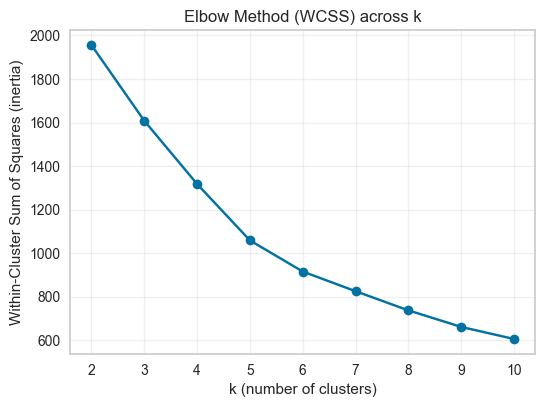

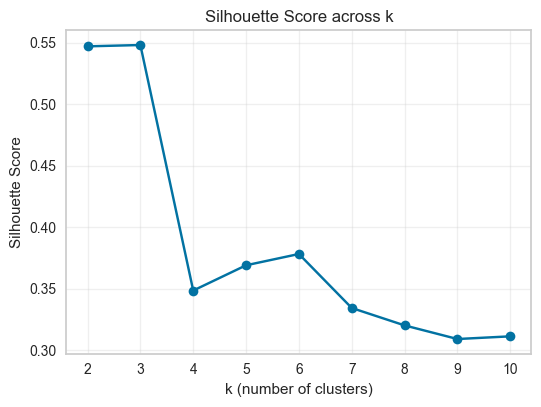

K selection summary (higher Silhouette is better; look for Elbow where WCSS drop diminishes):


,k,WCSS,Silhouette,Silhouette_rank,Elbow_delta
0,2,1956.124278,0.547215,2,NaN
1,3,1608.431149,0.548287,1,347.693129
2,4,1317.838361,0.348471,5,290.592788
3,5,1058.771253,0.369040,4,259.067107
4,6,915.741260,0.378229,3,143.029994
5,7,825.400252,0.334282,6,90.341008
6,8,737.386203,0.320116,7,88.014049
7,9,661.449585,0.309028,9,75.936619
8,10,605.915109,0.311214,8,55.534475



Best k by Silhouette in this sweep: k = 3


In [16]:
# Cell 11 — K selection study: Elbow (WCSS) + Silhouette across k (PyCaret 3.x safe)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from pycaret.clustering import get_config

# Get transformed feature matrix from PyCaret 3.x
# Prefer X_transformed; fall back to pipeline.transform(X) if needed
try:
    Xn = get_config('X_transformed')
except Exception:
    pipe = get_config('pipeline')
    X = get_config('X')  # raw features used in setup()
    Xn = pipe.transform(X)

# Ensure it's a NumPy float array
if hasattr(Xn, "to_numpy"):
    Xn = Xn.to_numpy()
Xn = np.asarray(Xn, dtype=float)

# Range of k to test
k_values = list(range(2, 11))
wcss, silh = [], []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=SEED, n_init=10)
    labels = km.fit_predict(Xn)
    wcss.append(km.inertia_)
    silh.append(silhouette_score(Xn, labels))

# Plot Elbow (WCSS)
plt.figure(figsize=(6.0,4.2))
plt.plot(k_values, wcss, marker='o')
plt.title("Elbow Method (WCSS) across k")
plt.xlabel("k (number of clusters)")
plt.ylabel("Within-Cluster Sum of Squares (inertia)")
plt.xticks(k_values)
plt.grid(True, alpha=0.3)
plt.show()

# Plot Silhouette
plt.figure(figsize=(6.0,4.2))
plt.plot(k_values, silh, marker='o')
plt.title("Silhouette Score across k")
plt.xlabel("k (number of clusters)")
plt.ylabel("Silhouette Score")
plt.xticks(k_values)
plt.grid(True, alpha=0.3)
plt.show()

# Summary table
summary = pd.DataFrame({"k": k_values, "WCSS": wcss, "Silhouette": silh})
summary["Silhouette_rank"] = summary["Silhouette"].rank(ascending=False, method="min").astype(int)
summary["Elbow_delta"] = (-summary["WCSS"].diff()).fillna(np.nan)  # drop in WCSS between successive k
print("K selection summary (higher Silhouette is better; look for Elbow where WCSS drop diminishes):")
display(summary)

best_k_by_sil = int(summary.loc[summary["Silhouette"].idxmax(), "k"])
print(f"\nBest k by Silhouette in this sweep: k = {best_k_by_sil}")


Locking KMeans with k = 3


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4583,132.3631,1.2491,0,0,0



New labeled head (final KMeans):


,fresh,milk,grocery,frozen,detergents_paper,delicassen,Cluster
0,12669,9656,7561,214,2674,1338,Cluster 0
1,7057,9810,9568,1762,3293,1776,Cluster 0
2,6353,8808,7684,2405,3516,7844,Cluster 0
3,13265,1196,4221,6404,507,1788,Cluster 0
4,22615,5410,7198,3915,1777,5185,Cluster 1



Cluster sizes — Final KMeans:


,Count
Cluster,
Cluster 0,350
Cluster 1,53
Cluster 2,37



Cluster sizes — Previous BEST_MODEL (for reference):


,Count
Cluster,
Cluster 0,42
Cluster 1,14
Cluster 2,1
Cluster 3,383



Numeric profiles (means) — Final KMeans:


,fresh,milk,grocery,frozen,detergents_paper,delicassen
Cluster,,,,,,
Cluster 0,8935.50,4228.53,5848.03,2167.23,1913.61,1102.12
Cluster 1,34540.11,5860.36,6122.62,9841.74,981.47,3664.25
Cluster 2,8704.86,20534.41,30466.24,1932.62,14758.84,2459.35



Cluster scatter (PyCaret):



Silhouette (PyCaret):


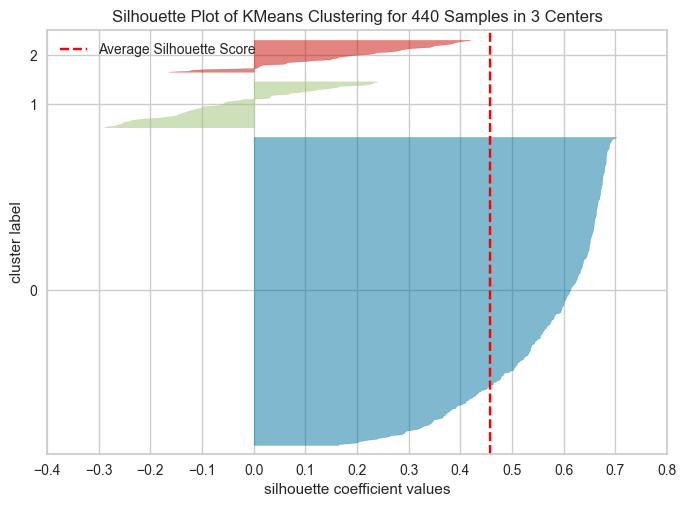


Set DF_CLUSTERED_FINALK, KMEANS_FINAL and BEST_INFO_FINALK for later use.


In [17]:
# Cell 12 — Lock in best-k KMeans, relabel data, and compare with previous clusters

import numpy as np
import pandas as pd
from pycaret.clustering import create_model, assign_model, plot_model

# 0) Get a k to lock in.
#    If you ran Cell 11, 'summary' and 'best_k_by_sil' should exist.
#    Otherwise, default to 5 (a common choice for this dataset).
if 'best_k_by_sil' in globals():
    k_final = int(best_k_by_sil)
else:
    k_final = 5
print(f"Locking KMeans with k = {k_final}")

# 1) Fit a fresh KMeans(k = k_final) in the current PyCaret session
kmeans_final = create_model('kmeans', num_clusters=k_final)

# 2) Assign labels to the modeling dataset
df_final = assign_model(kmeans_final).copy()

print("\nNew labeled head (final KMeans):")
display(df_final.head())

# 3) Compare cluster size distributions vs previous BEST (if available)
def _sizes(df):
    return df['Cluster'].value_counts().sort_index().rename_axis('Cluster').to_frame('Count')

sizes_final = _sizes(df_final)

print("\nCluster sizes — Final KMeans:")
display(sizes_final)

if 'DF_CLUSTERED' in globals():
    sizes_prev = _sizes(DF_CLUSTERED)
    print("\nCluster sizes — Previous BEST_MODEL (for reference):")
    display(sizes_prev)

# 4) Quick numeric profiles on original scale (means)
num_cols = df_final.select_dtypes(include=['number']).columns.tolist()
for ex in ['Anomaly','Score','Distance','Density']:
    if ex in num_cols: num_cols.remove(ex)

profiles_final = (
    df_final[num_cols + ['Cluster']]
    .groupby('Cluster')
    .mean(numeric_only=True)
    .round(2)
    .sort_index()
)

print("\nNumeric profiles (means) — Final KMeans:")
display(profiles_final)

# 5) Visual diagnostics for the locked K (skip gracefully if unsupported)
try:
    print("\nCluster scatter (PyCaret):")
    plot_model(kmeans_final, plot='cluster')
except Exception as e:
    print(f"Skipping 'cluster' plot: {e}")

try:
    print("\nSilhouette (PyCaret):")
    plot_model(kmeans_final, plot='silhouette')
except Exception as e:
    print(f"Skipping 'silhouette' plot: {e}")

# 6) Persist references for downstream cells/exports
DF_CLUSTERED_FINALK = df_final
KMEANS_FINAL = kmeans_final
BEST_INFO_FINALK = {'model_id': 'kmeans', 'num_clusters': k_final}

print("\nSet DF_CLUSTERED_FINALK, KMEANS_FINAL and BEST_INFO_FINALK for later use.")


In [18]:
# Cell 13 — Patch: robust prev→final label mapping when labels are strings like "Cluster 0"

import numpy as np
import pandas as pd

# Recreate aligned + contingency if needed
left = DF_CLUSTERED[['Cluster']].rename(columns={'Cluster': 'Cluster_prev'}).copy()
right = DF_CLUSTERED_FINALK[['Cluster']].rename(columns={'Cluster': 'Cluster_final'}).copy()
aligned = left.join(right, how='inner')

cont = pd.crosstab(aligned['Cluster_prev'], aligned['Cluster_final'])
print("Contingency (prev vs final-k):")
display(cont)

# Greedy mapping using labels as-is (no int() casting)
mapping = {}
cont_copy = cont.copy()

while cont_copy.size and cont_copy.values.sum() > 0:
    i, j = np.unravel_index(cont_copy.values.argmax(), cont_copy.shape)
    prev_lab = cont_copy.index[i]
    final_lab = cont_copy.columns[j]
    mapping[prev_lab] = final_lab
    cont_copy = cont_copy.drop(index=prev_lab, errors='ignore')
    cont_copy = cont_copy.drop(columns=final_lab, errors='ignore')

print("\nGreedy prev→final mapping:")
for p, f in mapping.items():
    print(f"  {p} → {f}")

# Add mapped ID to the aligned frame
aligned['Prev_mapped_to_final'] = aligned['Cluster_prev'].map(mapping)

print("\nAligned with mapped labels (head):")
display(aligned.head())

# (Optional) Save the mapping and aligned comparison
comp_dir = "final_artifacts"
os.makedirs(comp_dir, exist_ok=True)
pd.Series(mapping, name='final_label').to_frame().rename_axis('prev_label').to_csv(
    os.path.join(comp_dir, "label_mapping_prev_to_final.csv")
)
aligned.to_csv(os.path.join(comp_dir, "labels_prev_vs_final_with_mapping.csv"), index=True)
print(f"\nSaved mapping and aligned labels to: {os.path.abspath(comp_dir)}")


Contingency (prev vs final-k):


Cluster_final,Cluster 0,Cluster 1,Cluster 2
Cluster_prev,,,
Cluster 0,7,0,35
Cluster 1,0,13,1
Cluster 2,0,1,0
Cluster 3,343,39,1



Greedy prev→final mapping:
  Cluster 3 → Cluster 0
  Cluster 0 → Cluster 2
  Cluster 1 → Cluster 1

Aligned with mapped labels (head):


,Cluster_prev,Cluster_final,Prev_mapped_to_final
0,Cluster 3,Cluster 0,Cluster 0
1,Cluster 3,Cluster 0,Cluster 0
2,Cluster 3,Cluster 0,Cluster 0
3,Cluster 3,Cluster 0,Cluster 0
4,Cluster 3,Cluster 1,Cluster 0



Saved mapping and aligned labels to: /Users/kartikeysharma/Documents/pycaret-assignment/final_artifacts


In [19]:
# Cell 14 — One-click final summary report (HTML + Markdown) with metrics, mapping, profiles & plots

import os, json, datetime as dt
import numpy as np
import pandas as pd

# ---- Preconditions / graceful fallbacks ----
has_prev = 'DF_CLUSTERED' in globals()
has_final = 'DF_CLUSTERED_FINALK' in globals()
assert has_final or has_prev, "Run Cell 4 (DF_CLUSTERED) or Cell 12 (DF_CLUSTERED_FINALK) first."

df_prev = DF_CLUSTERED.copy() if has_prev else None
df_final = DF_CLUSTERED_FINALK.copy() if has_final else DF_CLUSTERED.copy()

# BEST_INFO objects
best_info_prev = globals().get('BEST_INFO', None)
best_info_final = globals().get('BEST_INFO_FINALK', None)

# metrics from comparison (if computed in Cell 13)
ARI = globals().get('ari', None)
NMI = globals().get('nmi', None)

# label mapping from patch cell (if available)
mapping_path = None
mapping = {}
if os.path.exists("final_artifacts/label_mapping_prev_to_final.csv"):
    mdf = pd.read_csv("final_artifacts/label_mapping_prev_to_final.csv", index_col=0)
    mapping = {k: v for k, v in zip(mdf.index, mdf['final_label'])}
    mapping_path = "final_artifacts/label_mapping_prev_to_final.csv"

# ---- Build summaries ----
def _sizes(df):
    return (df['Cluster'].value_counts()
                .sort_index()
                .rename_axis('Cluster')
                .to_frame('Count'))

def _numeric_profiles(df):
    num_cols = df.select_dtypes(include=['number']).columns.tolist()
    for ex in ['Anomaly','Score','Distance','Density']:
        if ex in num_cols: num_cols.remove(ex)
    return (df[num_cols + ['Cluster']]
              .groupby('Cluster')
              .mean(numeric_only=True)
              .round(2)
              .sort_index())

sizes_final = _sizes(df_final)
profiles_final = _numeric_profiles(df_final)

sizes_prev = _sizes(df_prev) if has_prev else None
profiles_prev = _numeric_profiles(df_prev) if has_prev else None

# Try to reference previously saved plots
plots = []
for img in ["final_artifacts/scatter_income_vs_spending.png",
            "final_artifacts/cluster_sizes_bar.png"]:
    if os.path.exists(img):
        plots.append(img)

# ---- Write HTML report (no external deps) ----
out_dir = "final_artifacts"
os.makedirs(out_dir, exist_ok=True)
html_path = os.path.join(out_dir, "final_summary.html")
md_path = os.path.join(out_dir, "final_summary.md")
json_path = os.path.join(out_dir, "final_summary.json")

def _df_html(df, title):
    return f"<h2>{title}</h2><div style='overflow-x:auto'>{df.to_html(index=True, border=0)}</div>"

def _df_md(df, title):
    return "\n".join([f"## {title}", "```", df.to_string(), "```", ""])

# HTML
html_sections = []
html_sections.append("<h1>Mall Customers — Final Clustering Summary</h1>")
# Model info lines
model_lines = []
if best_info_prev:
    model_lines.append(f"<li>Previous BEST: <b>{best_info_prev.get('model_id','')}</b>" +
                       (f" (k={best_info_prev.get('num_clusters')})" if best_info_prev.get('model_id')=='kmeans' and 'num_clusters' in best_info_prev else "") +
                       (f" — {best_info_prev.get('metric')}: {best_info_prev.get('score')}" if 'metric' in best_info_prev and 'score' in best_info_prev else "") +
                       "</li>")
if best_info_final:
    model_lines.append(f"<li>Final-k: <b>{best_info_final.get('model_id','')}</b>" +
                       (f" (k={best_info_final.get('num_clusters')})" if best_info_final.get('model_id')=='kmeans' and 'num_clusters' in best_info_final else "") +
                       "</li>")
if model_lines:
    html_sections.append("<ul>" + "".join(model_lines) + "</ul>")

# Agreement metrics if present
if ARI is not None or NMI is not None:
    html_sections.append(f"<p><b>Agreement (Prev vs Final-k):</b> ARI={ARI:.4f}, NMI={NMI:.4f}</p>")

# Sizes & profiles
if has_prev:
    html_sections.append(_df_html(sizes_prev, "Cluster Sizes — Previous"))
    html_sections.append(_df_html(profiles_prev, "Numeric Profiles (means) — Previous"))
html_sections.append(_df_html(sizes_final, "Cluster Sizes — Final-k"))
html_sections.append(_df_html(profiles_final, "Numeric Profiles (means) — Final-k"))

# Label mapping (optional)
if mapping:
    mseries = pd.Series(mapping, name='final_label').to_frame().rename_axis('prev_label')
    html_sections.append(_df_html(mseries, "Prev → Final-k Label Mapping"))

# Plots
for p in plots:
    html_sections.append(f"<h2>{os.path.basename(p)}</h2>")
    rel = os.path.basename(p)  # keep relative within folder
    html_sections.append(f"<img src='{rel}' style='max-width:100%;height:auto;border:1px solid #ddd;border-radius:8px;'>")

timestamp = dt.datetime.now().isoformat(timespec='seconds')
html_doc = f"""<!DOCTYPE html>
<html>
<head>
<meta charset="utf-8">
<title>Final Clustering Summary</title>
<style>
body {{ font-family: -apple-system, Segoe UI, Roboto, Helvetica, Arial, sans-serif; margin: 24px; }}
table {{ border-collapse: collapse; }}
th, td {{ padding: 6px 10px; border-bottom: 1px solid #eee; text-align: right; }}
th:first-child, td:first-child {{ text-align: left; }}
h1, h2 {{ margin-top: 28px; }}
</style>
</head>
<body>
{''.join(html_sections)}
<p style="color:#777;font-size:12px;">Generated: {timestamp}</p>
</body>
</html>
"""
with open(html_path, "w", encoding="utf-8") as f:
    f.write(html_doc)

# Markdown fallback (no 'tabulate' dependency)
md_lines = []
md_lines.append("# Mall Customers — Final Clustering Summary")
if best_info_prev:
    line = f"- Previous BEST: **{best_info_prev.get('model_id','')}**"
    if best_info_prev.get('model_id') == 'kmeans' and 'num_clusters' in best_info_prev:
        line += f" (k={best_info_prev['num_clusters']})"
    if 'metric' in best_info_prev and 'score' in best_info_prev:
        line += f" — {best_info_prev['metric']}: {best_info_prev['score']}"
    md_lines.append(line)
if best_info_final:
    line = f"- Final-k: **{best_info_final.get('model_id','')}**"
    if best_info_final.get('model_id') == 'kmeans' and 'num_clusters' in best_info_final:
        line += f" (k={best_info_final['num_clusters']})"
    md_lines.append(line)
if ARI is not None or NMI is not None:
    md_lines.append(f"- Agreement (Prev vs Final-k): ARI={ARI:.4f}, NMI={NMI:.4f}")
md_lines.append("")
if has_prev:
    md_lines.append(_df_md(sizes_prev, "Cluster Sizes — Previous"))
    md_lines.append(_df_md(profiles_prev, "Numeric Profiles (means) — Previous"))
md_lines.append(_df_md(sizes_final, "Cluster Sizes — Final-k"))
md_lines.append(_df_md(profiles_final, "Numeric Profiles (means) — Final-k"))
if mapping:
    mseries = pd.Series(mapping, name='final_label').to_frame().rename_axis('prev_label')
    md_lines.append(_df_md(mseries, "Prev → Final-k Label Mapping"))
md_lines.append(f"_Generated: {timestamp}_")

with open(md_path, "w", encoding="utf-8") as f:
    f.write("\n".join(md_lines))

# Machine-readable summary
summary = {
    "prev_model": best_info_prev,
    "final_model": best_info_final,
    "agreement": {"ARI": float(ARI) if ARI is not None else None,
                  "NMI": float(NMI) if NMI is not None else None},
    "sizes_prev": sizes_prev.to_dict()["Count"] if has_prev else None,
    "sizes_final": sizes_final.to_dict()["Count"],
    "mapping_prev_to_final": mapping if mapping else None,
    "plots_included": [os.path.basename(p) for p in plots],
    "generated_at": timestamp,
}
with open(json_path, "w", encoding="utf-8") as f:
    json.dump(summary, f, indent=2)

print("Final summary written:")
print("  HTML :", os.path.abspath(html_path))
print("  MD   :", os.path.abspath(md_path))
print("  JSON :", os.path.abspath(json_path))


Final summary written:
  HTML : /Users/kartikeysharma/Documents/pycaret-assignment/final_artifacts/final_summary.html
  MD   : /Users/kartikeysharma/Documents/pycaret-assignment/final_artifacts/final_summary.md
  JSON : /Users/kartikeysharma/Documents/pycaret-assignment/final_artifacts/final_summary.json


In [20]:
# Cell 15 — Reusable function to rerun the full PyCaret clustering pipeline on ANY similar CSV

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pycaret.clustering import setup, create_model, assign_model, save_model, get_config

def run_clustering_pipeline(
    csv_path: str,
    id_cols=("customerid",),
    feature_subset=None,          # e.g., ['annual_income_(k$)', 'spending_score_(1-100)']
    k_candidates=(3,4,5,6,7,8),
    model_base="models/generic_clustering_pipeline",
    seed=42,
    normalize=True,
    normalize_method="zscore"
):
    """
    Load a CSV, set up PyCaret clustering, sweep KMeans over k_candidates,
    pick the best by silhouette, assign labels, export artifacts, and save the model pipeline.

    Returns a dict with artifacts (DataFrames and paths).
    """
    assert os.path.exists(csv_path), f"CSV not found: {csv_path}"
    df_raw = pd.read_csv(csv_path)

    # Standardize column names
    df_raw.columns = (
        df_raw.columns
        .str.strip()
        .str.replace(r"\s+", "_", regex=True)
        .str.lower()
    )

    # Drop identifier columns if present
    df = df_raw.copy()
    for c in id_cols:
        if c in df.columns:
            df = df.drop(columns=[c])

    # Optional feature subset
    if feature_subset:
        keep = [c for c in feature_subset if c in df.columns]
        if not keep:
            raise ValueError(f"None of feature_subset columns found. Present: {list(df.columns)}")
        df = df[keep]

    # PyCaret setup
    setup(
        data=df,
        session_id=seed,
        normalize=normalize,
        normalize_method=normalize_method,
        verbose=False,
        html=False
    )

    # Manual sweep for KMeans k
    from pycaret.clustering import create_model, pull
    results = []
    trained = {}

    for k in k_candidates:
        try:
            m = create_model('kmeans', num_clusters=int(k))
            res = pull().copy()
            res['model_id'] = 'kmeans'
            res['k'] = int(k)
            results.append(res)
            trained[f'kmeans_{k}'] = m
        except Exception as e:
            print(f"Skipping KMeans(k={k}) due to error: {e}")

    if not results:
        raise RuntimeError("No successful KMeans fits. Check data and k_candidates.")

    all_res = pd.concat(results, ignore_index=True)
    sil_cols = [c for c in all_res.columns if c.strip().lower().startswith('silhouette')]
    if not sil_cols:
        raise RuntimeError(f"Silhouette column not found in results. Columns: {all_res.columns.tolist()}")
    sil_col = sil_cols[0]

    best_row = all_res.sort_values(by=sil_col, ascending=False).iloc[0]
    best_k = int(best_row['k'])
    best_model = trained[f'kmeans_{best_k}']

    # Assign labels
    from pycaret.clustering import assign_model
    df_labeled = assign_model(best_model).copy()

    # Save pipeline
    os.makedirs(os.path.dirname(model_base), exist_ok=True)
    save_model(best_model, model_base)

    # Build quick profiles
    num_cols = df_labeled.select_dtypes(include=['number']).columns.tolist()
    for ex in ['Anomaly','Score','Distance','Density']:
        if ex in num_cols: num_cols.remove(ex)
    profiles = (
        df_labeled[num_cols + ['Cluster']]
        .groupby('Cluster')
        .mean(numeric_only=True)
        .round(2)
        .sort_index()
    )
    sizes = df_labeled['Cluster'].value_counts().sort_index().rename_axis('Cluster').to_frame('Count')

    # Export CSVs
    base_dir = "pipeline_run_outputs"
    os.makedirs(base_dir, exist_ok=True)
    out_clustered = os.path.join(base_dir, "clustered.csv")
    out_sizes = os.path.join(base_dir, "cluster_sizes.csv")
    out_profiles = os.path.join(base_dir, "cluster_numeric_profiles.csv")

    df_labeled.to_csv(out_clustered, index=False)
    sizes.to_csv(out_sizes)
    profiles.to_csv(out_profiles)

    # Return artifacts
    return {
        "csv_input": os.path.abspath(csv_path),
        "best_k": best_k,
        "silhouette": float(best_row[sil_col]),
        "clustered_df": df_labeled,
        "sizes": sizes,
        "profiles": profiles,
        "model_path_base": os.path.abspath(model_base),
        "exports": {
            "clustered_csv": os.path.abspath(out_clustered),
            "sizes_csv": os.path.abspath(out_sizes),
            "profiles_csv": os.path.abspath(out_profiles)
        }
    }

# --- Example usage (commented) ---
# artifacts = run_clustering_pipeline(
#     csv_path="Mall_Customers.csv",
#     id_cols=("customerid",),
#     feature_subset=None,             # or ['annual_income_(k$)', 'spending_score_(1-100)']
#     k_candidates=range(3, 10),
#     model_base="models/mall_pipeline_rerun",
#     seed=SEED
# )
# print("Best k:", artifacts["best_k"], "Silhouette:", artifacts["silhouette"])
# display(artifacts["sizes"]); display(artifacts["profiles"])
# display(artifacts["clustered_df"].head())
